# Playing with UCI Bike Sharing Data

Links:
- [Data source and description](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)

## Data preprocessing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.optimize import brute
from scipy.stats import norm
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from download_data import download_data

pd.options.display.float_format = "{:,.2f}".format

Download data from the source to the local `data` directory. The function can be found in the same directory as this notebook.

In [2]:
local_data_dir = download_data()

Define a few labels for convenience.

In [3]:
lbl_date = "dteday"
lbl_prediction = "prediction"
lbl_holiday = "holiday"
lbl_weekday = "weekday"
lbl_workingday = "workingday"
lbl_weathersit = "weathersit"
lbl_season = "season"
lbl_temp = "temp"
lbl_hum = "hum"
lbl_windspeed = "windspeed"
lbl_count_of_rental_bikes = "cnt"

Load data from local drive

In [4]:
raw_data = pd.read_csv(local_data_dir / "day.csv", parse_dates=[lbl_date])
raw_data.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
726,727,2012-12-27,1,1,12,0,4,1,2,0.25,0.23,0.65,0.35,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.25,0.26,0.59,0.16,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.25,0.24,0.75,0.12,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.26,0.23,0.48,0.35,364,1432,1796
730,731,2012-12-31,1,1,12,0,1,1,2,0.22,0.22,0.58,0.15,439,2290,2729


Check data types and number of non-null values

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     731 non-null    int64         
 1   dteday      731 non-null    datetime64[ns]
 2   season      731 non-null    int64         
 3   yr          731 non-null    int64         
 4   mnth        731 non-null    int64         
 5   holiday     731 non-null    int64         
 6   weekday     731 non-null    int64         
 7   workingday  731 non-null    int64         
 8   weathersit  731 non-null    int64         
 9   temp        731 non-null    float64       
 10  atemp       731 non-null    float64       
 11  hum         731 non-null    float64       
 12  windspeed   731 non-null    float64       
 13  casual      731 non-null    int64         
 14  registered  731 non-null    int64         
 15  cnt         731 non-null    int64         
dtypes: datetime64[ns](1), floa

Sanity check

In [6]:
raw_data.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.00,731.00,731.00,731.00,731.00,731.00,731.00,731.00,731.00,731.00,731.00,731.00,731.00,731.00,731.00
mean,366.00,2.50,0.50,6.52,0.03,3.00,0.68,1.40,0.50,0.47,0.63,0.19,848.18,"3,656.17","4,504.35"
std,211.17,1.11,0.50,3.45,0.17,2.00,0.47,0.54,0.18,0.16,0.14,0.08,686.62,"1,560.26","1,937.21"
min,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.06,0.08,0.00,0.02,2.00,20.00,22.00
25%,183.50,2.00,0.00,4.00,0.00,1.00,0.00,1.00,0.34,0.34,0.52,0.13,315.50,"2,497.00","3,152.00"
50%,366.00,3.00,1.00,7.00,0.00,3.00,1.00,1.00,0.50,0.49,0.63,0.18,713.00,"3,662.00","4,548.00"
75%,548.50,3.00,1.00,10.00,0.00,5.00,1.00,2.00,0.66,0.61,0.73,0.23,"1,096.00","4,776.50","5,956.00"
max,731.00,4.00,1.00,12.00,1.00,6.00,1.00,3.00,0.86,0.84,0.97,0.51,"3,410.00","6,946.00","8,714.00"


Any missing values?

In [7]:
raw_data.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Looks like the data is quite clean. No missing values. Several categorical variables, several binary, several continuous. Plenty of freedom to build an interesting model.

## First descriptive analysis

Split data into train and test. Last 30 days are in the test.

In [8]:
split_time = raw_data[lbl_date].max() - pd.DateOffset(days=30)
data_train = raw_data.pipe(lambda df: df[df[lbl_date] < split_time])
data_test = raw_data.pipe(lambda df: df[df[lbl_date] >= split_time])
y_train = data_train[lbl_count_of_rental_bikes]
y_test = data_test[lbl_count_of_rental_bikes]

data_train.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
695,696,2012-11-26,4,1,11,0,1,1,1,0.31,0.34,0.54,0.05,337,4750,5087
696,697,2012-11-27,4,1,11,0,2,1,2,0.29,0.28,0.79,0.24,123,3836,3959
697,698,2012-11-28,4,1,11,0,3,1,1,0.30,0.29,0.51,0.21,198,5062,5260
698,699,2012-11-29,4,1,11,0,4,1,1,0.28,0.30,0.56,0.12,243,5080,5323
699,700,2012-11-30,4,1,11,0,5,1,1,0.30,0.32,0.65,0.06,362,5306,5668


Visualize the number of rentals per day.

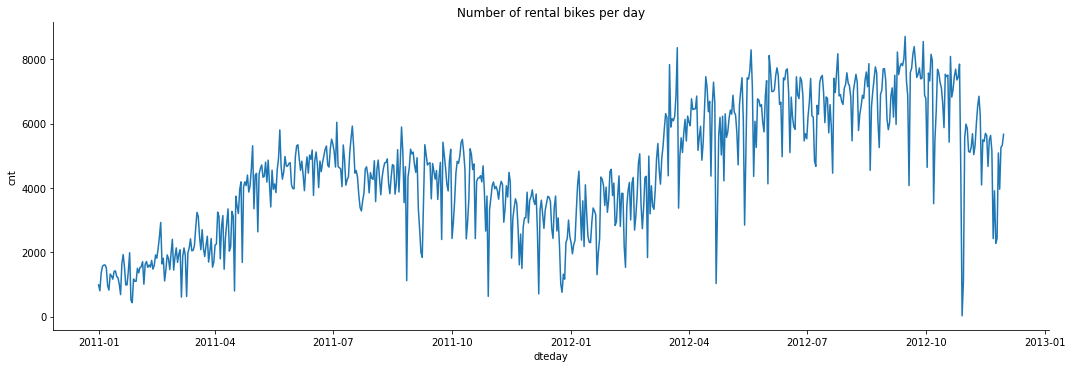

In [9]:
sns.relplot(
    x=lbl_date,
    y=lbl_count_of_rental_bikes,
    kind="line",
    aspect=3,
    data=data_train
)
plt.title("Number of rental bikes per day")
plt.show()

Compute the number of bikes needed on each day as a ratio of users and a maximum number of rentals per bike per day.

In [10]:
MAX_RENTALS_PER_BIKE_PER_DAY = 12
lbl_nr_of_bikes_needed_per_day = "number of bikes needed per day"
data_train = data_train.assign(
    **{lbl_nr_of_bikes_needed_per_day: lambda df: df[lbl_count_of_rental_bikes] / MAX_RENTALS_PER_BIKE_PER_DAY}
)

In [11]:
max_nr_of_bikes_needed = data_train[lbl_nr_of_bikes_needed_per_day].max()
print(f"Max number of bikes needed over all days in the data: {max_nr_of_bikes_needed:.0f}")

Max number of bikes needed over all days in the data: 726


In [12]:
alpha = 0.95
quantile_nr_of_bikes_needed = data_train[lbl_nr_of_bikes_needed_per_day].quantile(alpha)
print(f"{alpha:.0%} quantile number of bikes needed over all days in the data: {quantile_nr_of_bikes_needed:.0f}")

95% quantile number of bikes needed over all days in the data: 632


Let's set up a grid for a number of available bikes.

In [13]:
grid_bikes_available = np.linspace(start=0, stop=max_nr_of_bikes_needed, num=100)

Now compute the percentage of days that are completely covered by the set supply of bikes.

In [14]:
def get_pct_days_covered(data: pd.DataFrame, bikes_available: int) -> float:
    return 100 * (data[lbl_nr_of_bikes_needed_per_day] <= bikes_available).sum() / data.shape[0]

lbl_pct_bikes_available = "pct bikes available"
lbl_days_covered = "pct days covered"
pct_days_covered = list()
for bikes_available in grid_bikes_available:
    pct_days_covered.append(
        {lbl_pct_bikes_available: 100 * bikes_available / max_nr_of_bikes_needed,
         lbl_days_covered: get_pct_days_covered(data=data_train, bikes_available=bikes_available)}
    )
pct_days_covered = pd.DataFrame(pct_days_covered)
pct_days_covered.tail()

,pct bikes available,pct days covered
95,95.96,99.43
96,96.97,99.71
97,97.98,99.71
98,98.99,99.86
99,100.00,100.00


And visualize the result.

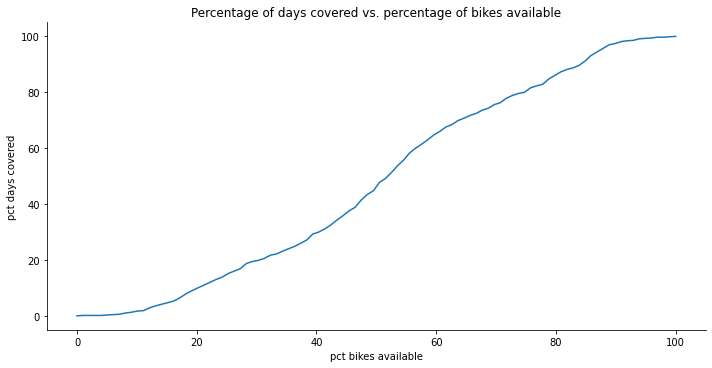

In [15]:
sns.relplot(
    x=lbl_pct_bikes_available,
    y=lbl_days_covered,
    kind="line",
    aspect=2,
    data=pct_days_covered,
)
plt.title("Percentage of days covered vs. percentage of bikes available")
plt.show()

In essence this plot shows the expected share of stochastic demand to be satisfied with a limited supply of bikes. The more bikes are available, the more riders will find a ride.

## Model train/fit/score

Now it's time to have fun with some models.

Let's use one hot encoder for a couple of categorical variables in the dataset.

In [16]:
categorical_features = [lbl_season, lbl_weathersit]
categorical_transformer = OneHotEncoder(sparse=False)

For continuous variables it is a prerequisite to use standard scaler especially in case of trees and forests.

In [17]:
continuous_features = [lbl_temp, lbl_hum, lbl_windspeed]
numeric_transformer = StandardScaler()

Binary features are good as they are. So the final data transformer is just a combination of the three with a final drop of unused data.

In [18]:
binary_features = [lbl_holiday, lbl_workingday]
data_transformer = ColumnTransformer(
    transformers=[
        ("binary features", "passthrough", binary_features),
        ("continuous features", numeric_transformer, continuous_features),
        ("categorical features", categorical_transformer, categorical_features)
    ], remainder="drop"
)

The model is just a standard random forest regression with a fixed number of estimators. We do not expect miracles from it, but we have to start somewhere.

In [19]:
model = RandomForestRegressor(n_estimators=5, random_state=42)

Let's wrap all this into a pipeline...

In [20]:
pipeline = make_pipeline(data_transformer, model)

... and see how it performs on the training data.

In [21]:
%%time

pipeline.fit(X=data_train, y=y_train)

r2_initial = pipeline.score(X=data_train, y=y_train)
print(f"initial R2 = {r2_initial:.0%}")

initial R2 = 90%
CPU times: user 40.4 ms, sys: 0 ns, total: 40.4 ms
Wall time: 67.3 ms


Around 90%. Not too bad for a first ball!

Let's take a look at the scatter of actual vs predicted.

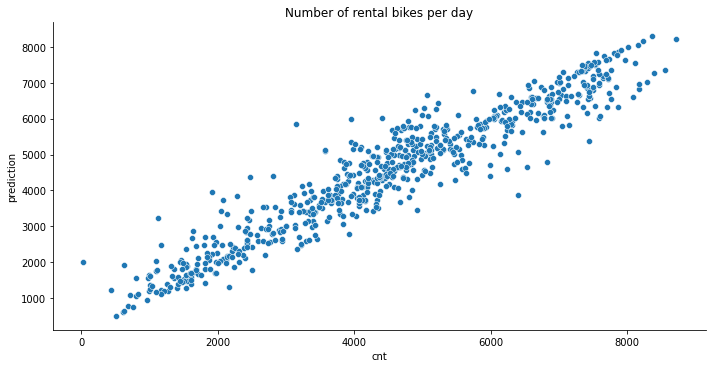

In [22]:
data_with_predictions = data_train.assign(
    **{lbl_prediction: pipeline.predict(X=data_train)}
)

sns.relplot(
    x=lbl_count_of_rental_bikes,
    y=lbl_prediction,
    aspect=2,
    data=data_with_predictions
)

plt.title("Number of rental bikes per day")
plt.show()

We can certainly do better :)

## Hyperparameter tuning

Below are all pipeline parameters that we can possibly tune.

In [23]:
pipeline.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('binary features', 'passthrough',
                                    ['holiday', 'workingday']),
                                   ('continuous features', StandardScaler(),
                                    ['temp', 'hum', 'windspeed']),
                                   ('categorical features',
                                    OneHotEncoder(sparse=False),
                                    ['season', 'weathersit'])])),
  ('randomforestregressor',
   RandomForestRegressor(n_estimators=5, random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('binary features', 'passthrough',
                                  ['holiday', 'workingday']),
                                 ('continuous features', StandardScaler(),
                                  ['temp', 'hum', 'windspeed']),
                                 ('categorical features',
                        

Just as a matter of proving a point, let's pick one (number of estimators in the random forest estimator) and use a standard grid search cross-validation.

In [24]:
%%time

param_grid = [{"randomforestregressor__n_estimators": [10, 100, 200, 500]}]
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid)
grid_search.fit(X=data_train, y=y_train)
grid_search_results = pd.DataFrame(grid_search.cv_results_)

CPU times: user 14.5 s, sys: 127 ms, total: 14.7 s
Wall time: 15.6 s


Results show us which model parameters produce better models. One should also pay attention to average fit time. It may become a limiting factor in production, scaling, further tuning, etc.

In [25]:
grid_search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.05,0.01,0.01,0.00,10,{'randomforestregressor__n_estimators': 10},-1.16,-6.77,-1.47,-1.37,-1.46,-2.45,2.17,4
1,0.33,0.05,0.02,0.00,100,{'randomforestregressor__n_estimators': 100},-1.05,-6.27,-1.24,-1.37,-1.39,-2.26,2.01,3
2,0.60,0.09,0.03,0.01,200,{'randomforestregressor__n_estimators': 200},-1.07,-6.27,-1.23,-1.37,-1.37,-2.26,2.01,2
3,1.67,0.39,0.09,0.02,500,{'randomforestregressor__n_estimators': 500},-1.07,-6.22,-1.21,-1.37,-1.35,-2.25,1.99,1


In [26]:
best_model = grid_search.best_estimator_
r2_best = best_model.score(X=data_train, y=y_train)
print(f"Initial R2 = {r2_initial:.0%}")
print(f"Best R2 = {r2_best:.0%}")
print(f"R2 improvement: {r2_best - r2_initial:.2%}")

Initial R2 = 90%
Best R2 = 95%
R2 improvement: 4.33%


4% is quite an improvement for a single hyperparameter!

## Profit optimization

Set some constants.

In [27]:
REVENUE_PER_RENTAL = 10
BIKE_COST_PER_DAY = 7

np.random.seed(42)

Predict the number of bikers on the test data.

In [28]:
predictions = best_model.predict(X=data_test)

Simulate demand for rental bikes by, first, simulating residuals from a simple Gaussian approximation of the regression error, and then second, adding those to the model predictions, and finally, dividing by the number of rentals per bike.

In [29]:
residuals = y_test - predictions
simulated_residuals = norm.rvs(loc=residuals.mean(), scale=residuals.std(), size=predictions.shape[0])
simulated_demand = (predictions + simulated_residuals) / MAX_RENTALS_PER_BIKE_PER_DAY

If we provide a fixed number of bikes on each day, there is no guarantee that all aspiring bikers would get one. Hence, a bike rental company would pocket only revenues from "satisfied" demand. Costs are of course independent on demand if supply is not flexible. So a simple profit formula is encapsulated in the function below.

In [30]:
def compute_profit(bikes_available: int) -> float:
    satisfied_demand = np.where(simulated_demand <= bikes_available, simulated_demand, bikes_available)
    return (satisfied_demand * REVENUE_PER_RENTAL - bikes_available * BIKE_COST_PER_DAY).sum()

profit_for_max_nr_of_bikes_needed = compute_profit(bikes_available=max_nr_of_bikes_needed)
print(f"Profit for maximum available number of bikes: {profit_for_max_nr_of_bikes_needed:.0f}")

Profit for maximum available number of bikes: -60167


Negative profit does not look too good neither for investors, nor for the owners of the company. So, let's compute the expected profit given a fixed supply of bikes.

In [31]:
profit = list()
lbl_profit = "profit"

for bikes_available in grid_bikes_available:
    profit.append(
        {lbl_pct_bikes_available: bikes_available / max_nr_of_bikes_needed,
         lbl_profit: compute_profit(bikes_available=bikes_available)}
    )
profit = pd.DataFrame(profit)

And use a straightforward brute force optimization to find the most profitable choice for a bike park.

In [32]:
%%time

def compute_loss(bikes_available: int) -> float:
    return -compute_profit(bikes_available=bikes_available)

grid = (slice(0, max_nr_of_bikes_needed, max_nr_of_bikes_needed / 10),)
opt_result = brute(func=compute_loss, ranges=grid, full_output=True)

print(f"Optimal number of bikes: {opt_result[0][0]:.0f}")
print(f"Expected profit: {-opt_result[1]:.0f}")

Optimal number of bikes: 222
Expected profit: 16417
CPU times: user 3.77 ms, sys: 269 µs, total: 4.04 ms
Wall time: 2.92 ms


Finally, visualize the profit function and the optimum.

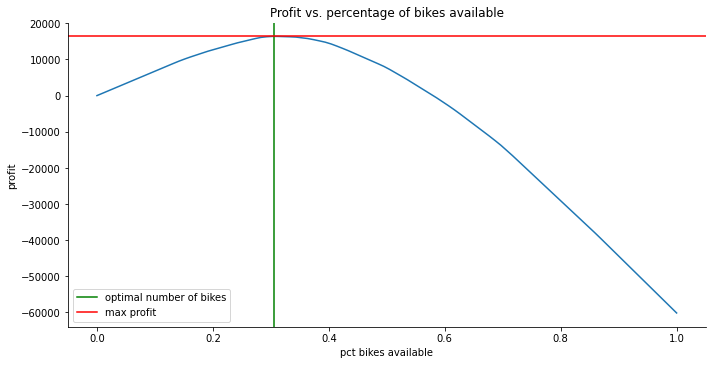

In [33]:
sns.relplot(
    x=lbl_pct_bikes_available,
    y=lbl_profit,
    kind="line",
    aspect=2,
    data=profit,
)
plt.axvline(opt_result[0] / max_nr_of_bikes_needed, color="green", label="optimal number of bikes")
plt.axhline(-opt_result[1], color="r", label="max profit")
plt.title("Profit vs. percentage of bikes available")
plt.legend()
plt.show()

The profit curve looks like an inverted parabola with a peak around 30% of bike availability. At first, the profit growth simply by providing a bare minimum of bikes on an empty market. At some point each additional supplied unit may be left untouched on some days, hence incurring the costs and not bringing in any revenue. If the number of bikes is too big, then the parking lot is full of brand-new bikes that are not utilized on majority of the days. Eventually, oversupply leads to the losses.

## Conclusion

There plenty of things to improve here. For example:
- `RandomForestRegressor` is probably not the best choice for a large scale random forest modelling. [`XGBoost`](https://xgboost.readthedocs.io/en/stable/) is most likely the current industry leader in this area.
- Hyperparameter tuning with a standard `GridSearchCV` is also probably suboptimal. Something like [`Hyperopt`](https://github.com/hyperopt/hyperopt) would probably be a better choice for large scale multidimensional problems.
- Feature engineering with simple `OneHotEncoder` and `StandardScaler` should definitely be upgraded. There is no deficit of packages for that purpose. See e.g. [here](https://github.com/EthicalML/awesome-production-machine-learning#feature-engineering-automation) for relevant libraries.
- Time and dynamic aspect in the above example was completely ignored. It is evident from the time series plot that there are some annual trends or even lower frequency variation on extended time intervals. Time series models should definitely be added to the list in order to adjust bike supply with greater precision. A short list of popular TS packages is: [Prophet](https://facebook.github.io/prophet/docs/quick_start.html), [Greykite](https://github.com/linkedin/greykite), [sktime](https://github.com/alan-turing-institute/sktime), [Darts](https://unit8co.github.io/darts/).
- For this specific problem neural networks would definitely be an overkill, but at scale they can not be ignored.
- Demand/supply/profit simulation above is a bare minimum. Distribution of errors, fixed supply, prices - all could be tweaked to better reflect a real market situation.